# Odev2 – Karınca Kolonisi Algoritması ile Yol Optimizasyonu (Senaryo 8)

**Adınız:** Ahmet Sudeys  
**Soyadınız:** Soylu  
**Okul Numaranız:** 2312721068  

**GitHub Repo Bağlantısı:** 
https://github.com/AhmetSudeys/yapay-zeka-proje-2


## 1) Problem Tanımı (Senaryo 8)

Bu projede, Isparta merkezde belirlenen 10 adet afet ve acil durum toplanma alanına bir acil durum nakliye dronunun
en kısa toplam yol uzunluğu ile uğrayabileceği tur (rota) bulunmuştur.

- Noktalar: 10 adet gerçek koordinat (enlem-boylam)
- Mesafe tipi: Google Maps "driving distance" (karayolu sürüş mesafesi)
- Amaç: Toplam tur mesafesini minimize eden rotayı bulmak (TSP benzeri problem)
- Yöntem: Karınca Kolonisi Algoritması (ACO)
- Arayüz: Streamlit (repo içinde)


## 2) Kullanılan Yaklaşım

1. Toplanma alanlarının koordinatları hazırlanır.
2. Google Maps Distance Matrix API ile noktalar arası sürüş mesafeleri alınır ve mesafe matrisi oluşturulur.
3. ACO algoritması, feromon izleri ve sezgisel bilgi (1/mesafe) kullanarak en kısa turu arar.
4. İterasyonlar boyunca bulunan en iyi mesafe kaydedilir ve yakınsama grafiği çizilir.


In [44]:
# Önce gerekli indirmeleri yapmamız gerekmektedir.
!pip install googlemaps matplotlib
!pip install pydeck pandas


In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
import googlemaps
import pandas as pd
import pydeck as pdk

In [46]:
# 10 adet toplanma alanı koordinatı (enlem, boylam)
NOKTALAR = [
    (37.76929243024278, 30.57191505113733),
    (37.76188880381494, 30.556300396938408),
    (37.761446387125375, 30.5581604641834),
    (37.75554124354504, 30.559385527588866),
    (37.75263971466984, 30.56807817040864),
    (37.75159041096415, 30.5614396780868),
    (37.758978364561486, 30.52991023557007),
    (37.7586361337514, 30.536689081596094),
    (37.77070748008167, 30.51963845460973),
    (37.77366598148224, 30.53413405460989)
]

NOKTA_ISIMLERI = [f"Toplanma Alani {i}" for i in range(1, 11)]

len(NOKTALAR), NOKTA_ISIMLERI[:3]

(10, ['Toplanma Alani 1', 'Toplanma Alani 2', 'Toplanma Alani 3'])

## 3) API Anahtarı Güvenliği

Google Maps API anahtarı notebook içine yazılmamıştır.
API anahtarı sistem ortam değişkeninden (environment variable) okunacaktır.

Örnek kullanım:
- Windows PowerShell:
  `$env:GOOGLE_MAPS_API_KEY="..."`

Bu sayede anahtar repo içinde paylaşılmaz.


In [47]:
# API key'i bu notebook icin tanimliyoruz
os.environ["GOOGLE_MAPS_API_KEY"] = "GİZLİLİK_AÇISINDAN_YAZILMAMIŞTIR" 

api_key = os.getenv("GOOGLE_MAPS_API_KEY")

if not api_key:
    raise ValueError("GOOGLE_MAPS_API_KEY bulunamadi")

gmaps = googlemaps.Client(key=api_key)
print("Google Maps client hazir.")


Google Maps client hazir.


In [48]:
def mesafe_matrisi_olustur(gmaps, koordinatlar, mode="driving"):
    noktalar = [f"{lat},{lng}" for lat, lng in koordinatlar]

    yanit = gmaps.distance_matrix(
        origins=noktalar,
        destinations=noktalar,
        mode=mode
    )

    n = len(noktalar)
    matris = np.zeros((n, n), dtype=int)

    for i in range(n):
        for j in range(n):
            eleman = yanit["rows"][i]["elements"][j]
            if eleman["status"] != "OK":
                raise ValueError(f"Mesafe alinamadi: {i}->{j}, status={eleman['status']}")
            matris[i, j] = eleman["distance"]["value"]  # metre

    return matris


In [49]:
mesafe_matrisi = mesafe_matrisi_olustur(gmaps, NOKTALAR, mode="driving")
mesafe_matrisi.shape, mesafe_matrisi[:3, :3]


((10, 10),
 array([[   0, 2172, 1834],
        [1891,    0,  303],
        [1930,  307,    0]]))

## 4) Karınca Kolonisi Algoritması (ACO) Mantığı

- Her karınca bir tur üretir: başlangıç noktasından başlayıp tüm noktaları bir kez ziyaret eder ve başlangıca geri döner.
- Bir sonraki şehir seçimi olasılıksaldır:
  - Feromon izi (tau): önceki iyi rotalardan kalan iz
  - Sezgisel bilgi (eta): 1/mesafe (yakın olan daha çekici)
- Parametreler:
  - α (alfa): feromon etkisi
  - β (beta): sezgisel bilginin etkisi
  - ρ (buharlaşma): feromonun zamanla azalması
- Her iterasyon sonunda en iyi tur güncellenebilir ve yakınsama grafiği bu yüzden düşerek sabitlenir.


In [50]:
def rota_mesafesi(rota, mesafe_matrisi):
    toplam = 0
    for i in range(len(rota) - 1):
        toplam += mesafe_matrisi[rota[i], rota[i+1]]
    return toplam


In [51]:
def olasilik_hesapla(mevcut, ziyaret_edildi, feromon, sezgisel, alfa, beta):
    n = feromon.shape[0]
    agirliklar = np.zeros(n, dtype=float)

    for j in range(n):
        if j in ziyaret_edildi:
            agirliklar[j] = 0.0
        else:
            agirliklar[j] = (feromon[mevcut, j] ** alfa) * (sezgisel[mevcut, j] ** beta)

    toplam = agirliklar.sum()
    if toplam == 0:
        secilebilir = [j for j in range(n) if j not in ziyaret_edildi]
        olasiliklar = np.zeros(n, dtype=float)
        pay = 1.0 / len(secilebilir)
        for j in secilebilir:
            olasiliklar[j] = pay
        return olasiliklar

    return agirliklar / toplam

def rota_uret(baslangic, feromon, sezgisel, alfa, beta):
    n = feromon.shape[0]
    ziyaret_edildi = set([baslangic])
    rota = [baslangic]

    while len(ziyaret_edildi) < n:
        mevcut = rota[-1]
        olasiliklar = olasilik_hesapla(mevcut, ziyaret_edildi, feromon, sezgisel, alfa, beta)
        secilen = np.random.choice(range(n), p=olasiliklar)
        rota.append(int(secilen))
        ziyaret_edildi.add(int(secilen))

    rota.append(baslangic)
    return rota

def aco_coz(mesafe_matrisi, karinca_sayisi=30, iterasyon_sayisi=80, alfa=1.0, beta=5.0, buharlas=0.5, baslangic=0):
    n = mesafe_matrisi.shape[0]

    feromon = np.ones((n, n), dtype=float)

    sezgisel = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            if i != j:
                sezgisel[i, j] = 1.0 / max(mesafe_matrisi[i, j], 1)

    en_iyi_rota = None
    en_iyi_mesafe = float("inf")
    tarihce = []

    for _ in range(iterasyon_sayisi):
        karinca_sonuclari = []

        for _ in range(karinca_sayisi):
            rota = rota_uret(baslangic, feromon, sezgisel, alfa, beta)
            mesafe = rota_mesafesi(rota, mesafe_matrisi)
            karinca_sonuclari.append((rota, mesafe))

            if mesafe < en_iyi_mesafe:
                en_iyi_mesafe = mesafe
                en_iyi_rota = rota

        tarihce.append(en_iyi_mesafe)

        feromon *= (1.0 - buharlas)

        for rota, mesafe in karinca_sonuclari:
            katkı = 1.0 / max(mesafe, 1)
            for i in range(len(rota) - 1):
                a = rota[i]
                b = rota[i+1]
                feromon[a, b] += katkı
                feromon[b, a] += katkı

    return en_iyi_rota, en_iyi_mesafe, tarihce


In [52]:
en_iyi_rota, en_iyi_mesafe, tarihce = aco_coz(
    mesafe_matrisi,
    karinca_sayisi=30,
    iterasyon_sayisi=80,
    alfa=1.0,
    beta=5.0,
    buharlas=0.5,
    baslangic=0
)

en_iyi_rota_isim = [f"{i} - {NOKTA_ISIMLERI[i]}" for i in en_iyi_rota]

print("En iyi rota (index):", en_iyi_rota)
print("En iyi rota (index - isim):", en_iyi_rota_isim)
print(f"Toplam mesafe: {en_iyi_mesafe/1000:.2f} km")


En iyi rota (index): [0, 9, 8, 6, 7, 1, 2, 3, 5, 4, 0]
En iyi rota (index - isim): ['0 - Toplanma Alani 1', '9 - Toplanma Alani 10', '8 - Toplanma Alani 9', '6 - Toplanma Alani 7', '7 - Toplanma Alani 8', '1 - Toplanma Alani 2', '2 - Toplanma Alani 3', '3 - Toplanma Alani 4', '5 - Toplanma Alani 6', '4 - Toplanma Alani 5', '0 - Toplanma Alani 1']
Toplam mesafe: 16.92 km


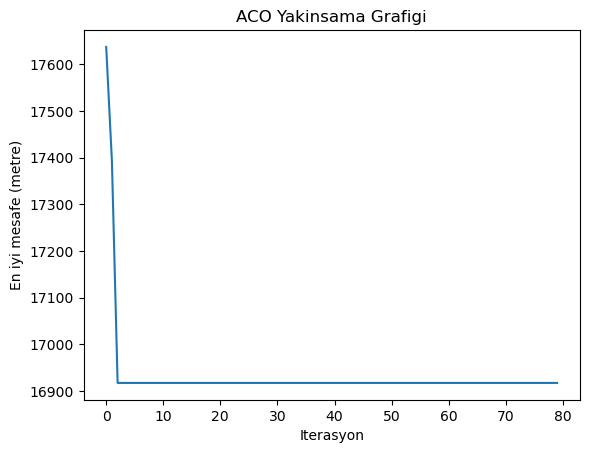

In [53]:
#Yakınsama Grafiği
plt.figure()
plt.plot(tarihce)
plt.xlabel("Iterasyon")
plt.ylabel("En iyi mesafe (metre)")
plt.title("ACO Yakinsama Grafigi")
plt.show()


In [54]:
#Maps üzerinde gösterme işlemleri
noktalar = []
for idx in en_iyi_rota:
    lat, lng = NOKTALAR[idx]
    noktalar.append({
        "lat": lat,
        "lon": lng,
        "isim": f"{idx} - {NOKTA_ISIMLERI[idx]}"
    })

df_nokta = pd.DataFrame(noktalar)

# Cizgi icin path listesi (lon, lat) sirasinda olmali
line_coords = [[row["lon"], row["lat"]] for _, row in df_nokta.iterrows()]
df_line = pd.DataFrame([{"path": line_coords}])

# Nokta katmani
layer_points = pdk.Layer(
    "ScatterplotLayer",
    data=df_nokta,
    get_position="[lon, lat]",
    get_radius=70,
    pickable=True
)

# Cizgi katmani (KIRMIZI)
layer_line = pdk.Layer(
    "PathLayer",
    data=df_line,
    get_path="path",
    get_color=[255, 0, 0],   # kirmizi
    width_scale=10,
    width_min_pixels=4
)

# Harita gorunumu
view_state = pdk.ViewState(
    latitude=df_nokta["lat"].mean(),
    longitude=df_nokta["lon"].mean(),
    zoom=12
)

deck = pdk.Deck(
    layers=[layer_line, layer_points],
    initial_view_state=view_state,
    tooltip={"text": "{isim}"}
)

deck

{
  "initialViewState": {
    "latitude": 37.76215267095288,
    "longitude": 30.551596924169687,
    "zoom": 12
  },
  "layers": [
    {
      "@@type": "PathLayer",
      "data": [
        {
          "path": [
            [
              30.57191505113733,
              37.76929243024278
            ],
            [
              30.53413405460989,
              37.77366598148224
            ],
            [
              30.51963845460973,
              37.77070748008167
            ],
            [
              30.52991023557007,
              37.758978364561486
            ],
            [
              30.536689081596094,
              37.7586361337514
            ],
            [
              30.556300396938408,
              37.76188880381494
            ],
            [
              30.5581604641834,
              37.761446387125375
            ],
            [
              30.559385527588866,
              37.75554124354504
            ],
            [
              30.5614396780868,
              37.75159041096415
            ],
            [
              30.56807817040864,
              37.75263971466984
            ],
            [
              30.57191505113733,
              37.76929243024278
            ]
          ]
        }
      ],
      "getColor": [
        255,
        0,
        0
      ],
      "getPath": "@@=path",
      "id": "679fc2b1-ff19-49cf-9b7c-dcc4b68bcb29",
      "widthMinPixels": 4,
      "widthScale": 10
    },
    {
      "@@type": "ScatterplotLayer",
      "data": [
        {
          "isim": "0 - Toplanma Alani 1",
          "lat": 37.76929243024278,
          "lon": 30.57191505113733
        },
        {
          "isim": "9 - Toplanma Alani 10",
          "lat": 37.77366598148224,
          "lon": 30.53413405460989
        },
        {
          "isim": "8 - Toplanma Alani 9",
          "lat": 37.77070748008167,
          "lon": 30.51963845460973
        },
        {
          "isim": "6 - Toplanma Alani 7",
          "lat": 37.758978364561486,
          "lon": 30.52991023557007
        },
        {
          "isim": "7 - Toplanma Alani 8",
          "lat": 37.7586361337514,
          "lon": 30.536689081596094
        },
        {
          "isim": "1 - Toplanma Alani 2",
          "lat": 37.76188880381494,
          "lon": 30.556300396938408
        },
        {
          "isim": "2 - Toplanma Alani 3",
          "lat": 37.761446387125375,
          "lon": 30.5581604641834
        },
        {
          "isim": "3 - Toplanma Alani 4",
          "lat": 37.75554124354504,
          "lon": 30.559385527588866
        },
        {
          "isim": "5 - Toplanma Alani 6",
          "lat": 37.75159041096415,
          "lon": 30.5614396780868
        },
        {
          "isim": "4 - Toplanma Alani 5",
          "lat": 37.75263971466984,
          "lon": 30.56807817040864
        },
        {
          "isim": "0 - Toplanma Alani 1",
          "lat": 37.76929243024278,
          "lon": 30.57191505113733
        }
      ],
      "getPosition": "@@=[lon, lat]",
      "getRadius": 70,
      "id": "83e54469-6719-4332-8488-3706951db690",
      "pickable": true
    }
  ],
  "mapProvider": "carto",
  "mapStyle": "https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json",
  "views": [
    {
      "@@type": "MapView",
      "controller": true
    }
  ]
}

## 5) Sonuç ve Yorum

- Google Maps Distance Matrix API kullanılarak gerçek sürüş mesafeleri ile mesafe matrisi oluşturulmuştur.
- ACO algoritması, iterasyonlar boyunca daha iyi turlar keşfederek toplam mesafeyi düşürmüştür.
- Yakınsama grafiği, belirli bir iterasyondan sonra en iyi çözümün sabitlendiğini göstermektedir.
- Streamlit arayüzünde kullanıcı parametre girerek farklı ACO ayarlarıyla çözüm üretebilmektedir.
